5 outlier(s) have been deleted.
The outlier(s) value(s) are : [292.96875, 253.90625, 289.0625, 253.90625, 230.46875]
9 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
4 ectopic beat(s) have been deleted with malik rule.
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with malik rule.
5 outlier(s) have been deleted.
The outlier(s) value(s) are : [292.96875, 253.90625, 289.0625, 253.90625, 230.46875]
18 ectopic beat(s) have been deleted with acar rule.
0 outlier(s) have been deleted.
2 ectopic beat(s) have been deleted with acar rule.
0 outlier(s) have been deleted.
3 ectopic beat(s) have been deleted with acar rule.


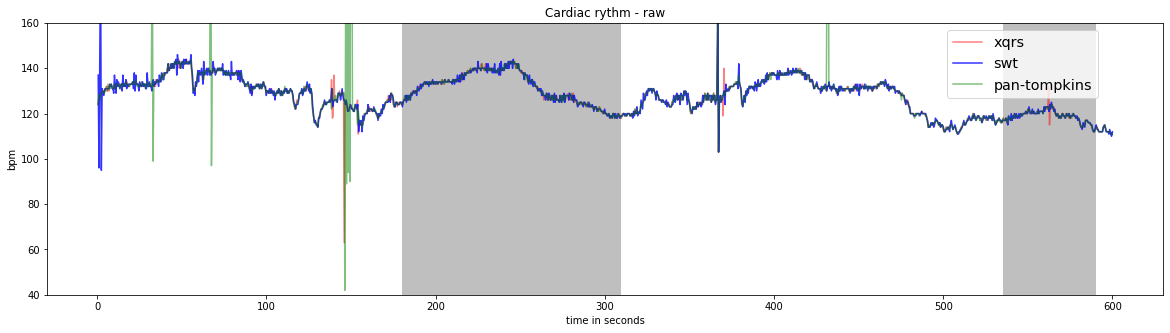

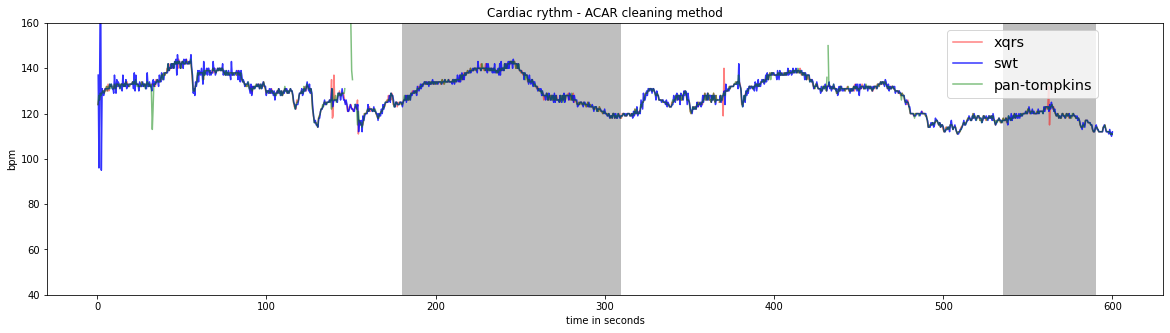

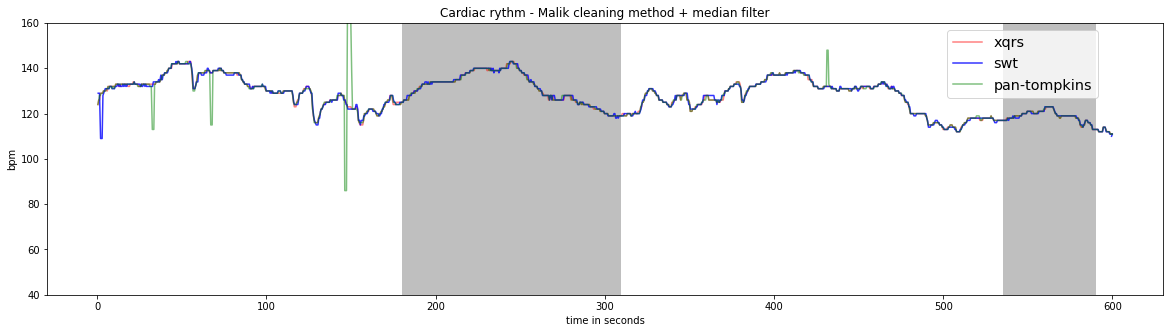

In [38]:
import glob
import json
import matplotlib.pyplot as plt
import numpy as np 
import math
import scipy.signal as signal
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values


def get_clean_intervals(rrs, method="malik"):
    # This remove outliers from signal
    rr_intervals_without_outliers = remove_outliers(rr_intervals=rrs,
                                                    low_rri=300, high_rri=1800)
    # This replace outliers nan values with linear interpolation
    interpolated_rr_intervals = interpolate_nan_values(rr_intervals=rr_intervals_without_outliers,
                                                       interpolation_method="linear")

    # This remove ectopic beats from signal
    nn_intervals_list = remove_ectopic_beats(rr_intervals=interpolated_rr_intervals, method=method)
    # This replace ectopic beats nan values with linear interpolation
    interpolated_nn_intervals = interpolate_nan_values(rr_intervals=nn_intervals_list)
    return interpolated_nn_intervals

def to_hr(rr_intervals):
    hr = np.zeros(len(rr_intervals))
    for i in range(0, len(rr_intervals)):
        if math.isnan(rr_intervals[i]):
            hr[i] = np.nan
        else:
            hr[i] = (int)(60 * 1000 / rr_intervals[i])

    return hr

ECG_FILE = "./010520T1514_99perc_seizures/test_data.json"
ANNOTATIONS_FILE = "./010520T1514_99perc_seizures/test_annot.json"

try:
    data = json.load(open(ECG_FILE, "r"))
    annotations = json.load(open(ANNOTATIONS_FILE, "r"))

    timestamps = {}
    timestamps["pan-tompkins"] = []
    timestamps["xqrs"] = []
    timestamps["swt"] = []

    for key in timestamps.keys():
        timestamps[key] = np.cumsum(data[key]["rr_intervals"][1:])
        timestamps[key] = np.append(timestamps[key], timestamps[key][-2])
        timestamps[key] *= 0.001


    clean_rr_intervals = {}
    clean_rr_intervals["pan-tompkins"] = get_clean_intervals(data["pan-tompkins"]["rr_intervals"])
    clean_rr_intervals["swt"] = get_clean_intervals(data["swt"]["rr_intervals"])
    clean_rr_intervals["xqrs"] = get_clean_intervals(data["xqrs"]["rr_intervals"])

    clean_hr = {}
    clean_hr["pan-tompkins"] = to_hr(clean_rr_intervals["pan-tompkins"])
    clean_hr["swt"] = to_hr(clean_rr_intervals["swt"])
    clean_hr["xqrs"] = to_hr(clean_rr_intervals["xqrs"])

    hr_median ={}
    hr_median["pan-tompkins"] = signal.medfilt(clean_hr["pan-tompkins"], 5)
    hr_median["swt"] = signal.medfilt(clean_hr["swt"], 5)
    hr_median["xqrs"] = signal.medfilt(clean_hr["xqrs"], 5)

    clean_rr_intervals_acar = {}
    clean_rr_intervals_acar["pan-tompkins"] = get_clean_intervals(data["pan-tompkins"]["rr_intervals"], method="acar")
    clean_rr_intervals_acar["swt"] = get_clean_intervals(data["swt"]["rr_intervals"], method="acar")
    clean_rr_intervals_acar["xqrs"] = get_clean_intervals(data["xqrs"]["rr_intervals"], method="acar")

    clean_hr_acar = {}
    clean_hr_acar["pan-tompkins"] = to_hr(clean_rr_intervals_acar["pan-tompkins"])
    clean_hr_acar["swt"] = to_hr(clean_rr_intervals_acar["swt"])
    clean_hr_acar["xqrs"] = to_hr(clean_rr_intervals_acar["xqrs"])
    
    #Raw RR intervals
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - raw")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], data["xqrs"]["hr"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], data["swt"]["hr"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], data["pan-tompkins"]["hr"],  color='green', alpha=0.5, label="pan-tompkins")
    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()

    # Clean  RR intervals with Acar method
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - ACAR cleaning method")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], clean_hr_acar["xqrs"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], clean_hr_acar["swt"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], clean_hr_acar["pan-tompkins"], color='green', alpha=0.5, label="pan-tompkins")
    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()
    
    # Clean RR intervals with Malik + median filter
    plt.figure(1, figsize = (20,5))
    plt.ylim((40, 160))
    plt.title("Cardiac rythm - Malik cleaning method + median filter")
    plt.xlabel("time in seconds")
    plt.ylabel("bpm")
    plt.plot(timestamps["xqrs"], hr_median["xqrs"], color='red', alpha=0.5, label="xqrs")
    plt.plot(timestamps["swt"], hr_median["swt"], color='blue', alpha=0.8, label="swt")
    plt.plot(timestamps["pan-tompkins"], hr_median["pan-tompkins"], color='green', alpha=0.5, label="pan-tompkins")

    for seizure in annotations["seizure"]:
        plt.axvspan(seizure[0], seizure[1], facecolor='grey', alpha=0.5)
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    plt.show()
except Exception as e:
    print(e)
    print("Error")
        
    
    

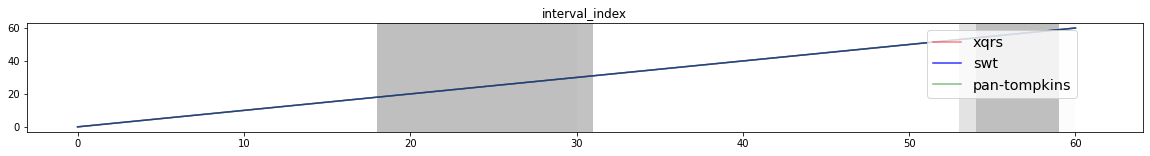

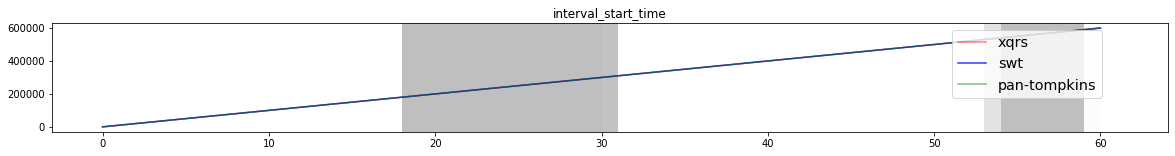

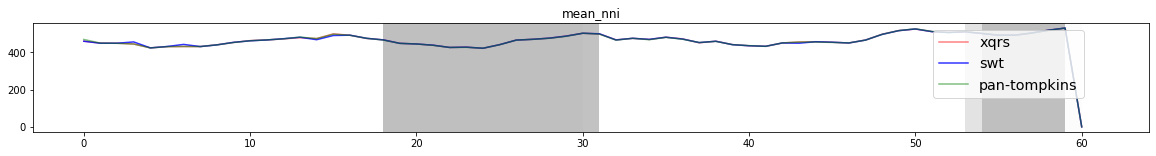

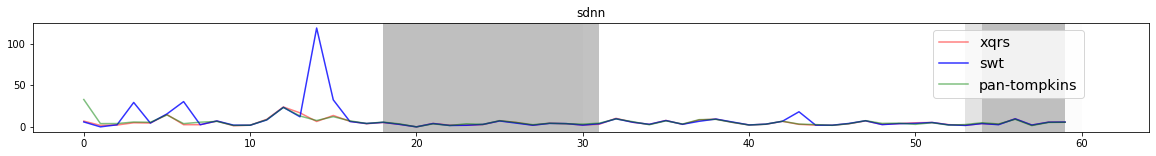

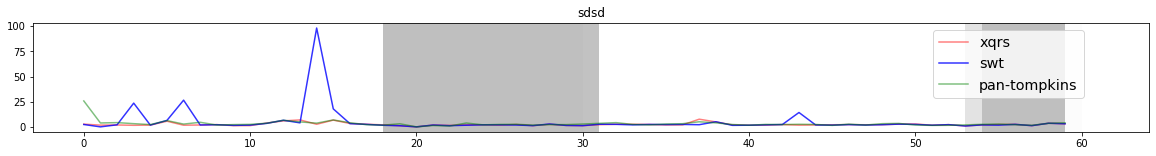

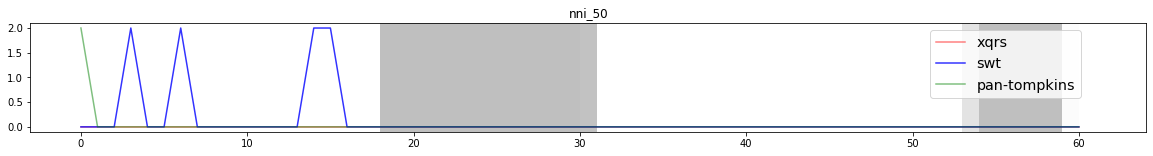

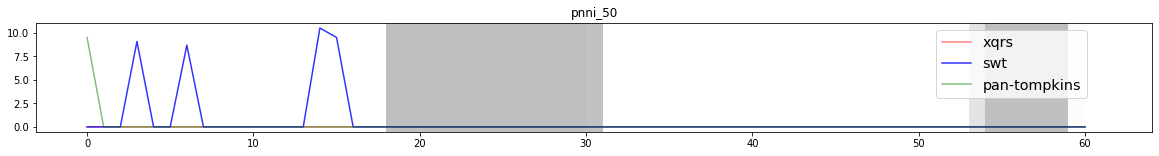

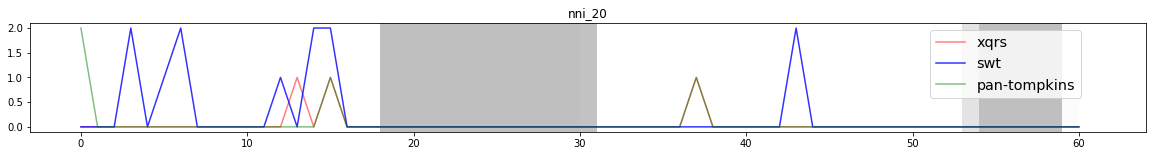

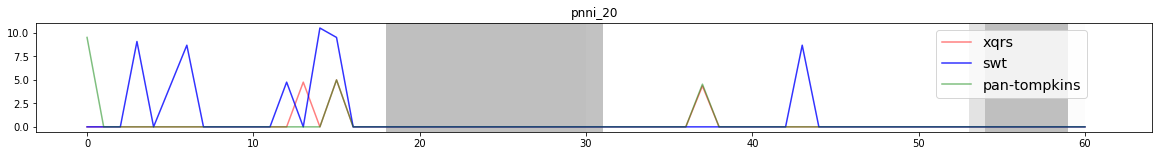

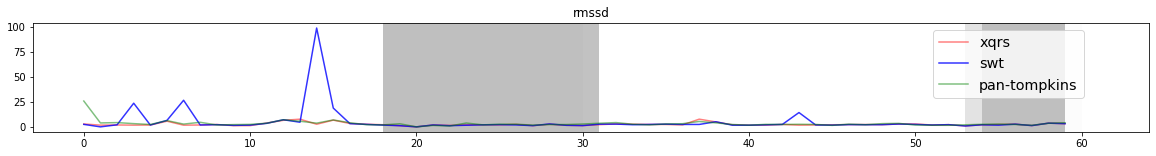

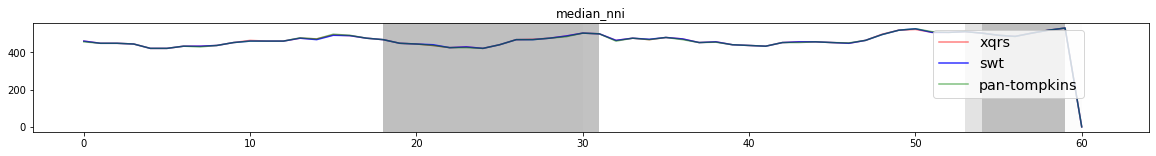

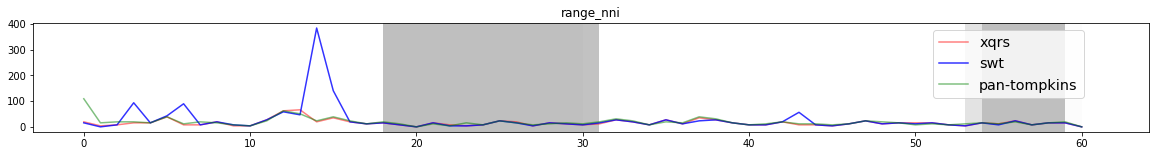

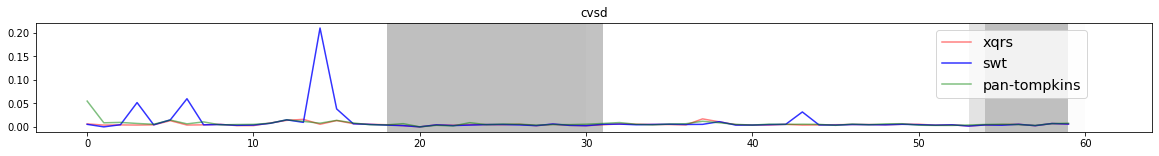

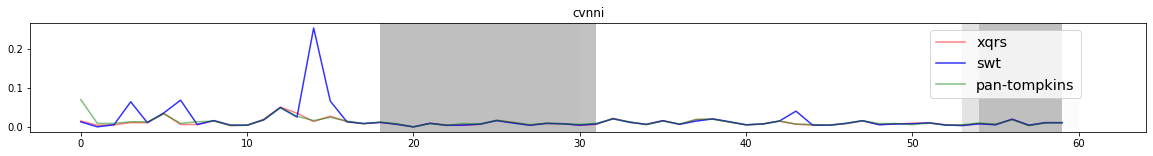

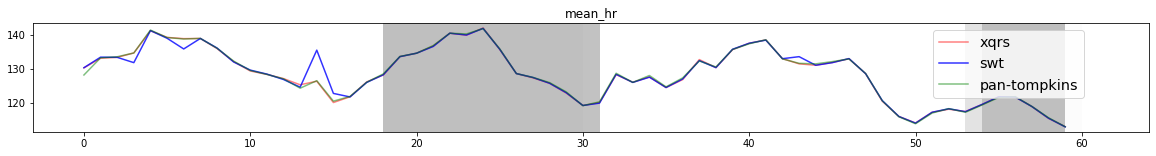

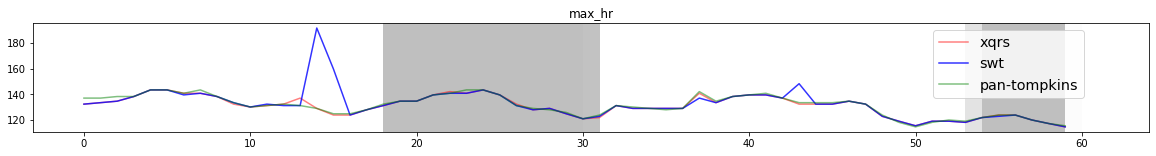

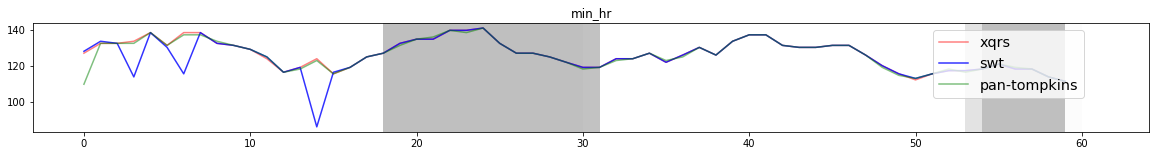

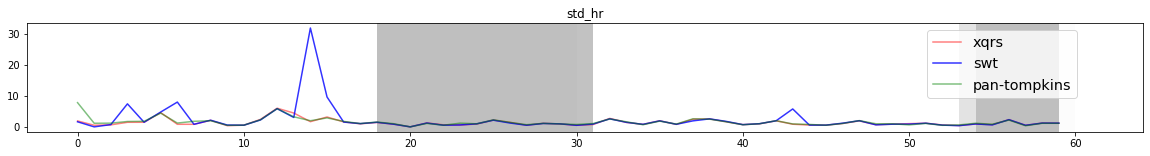

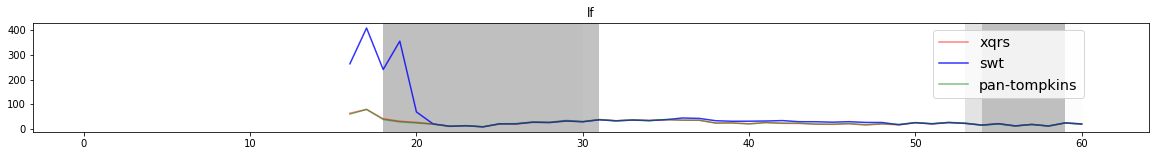

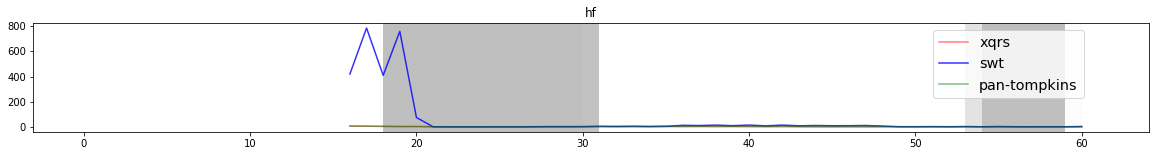

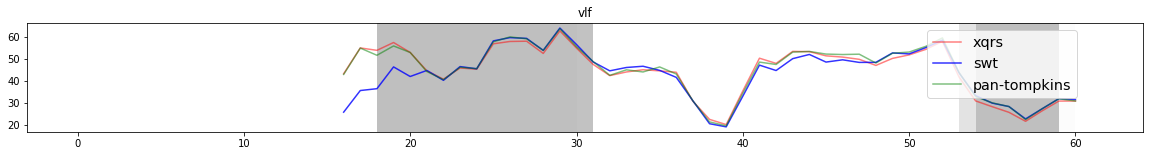

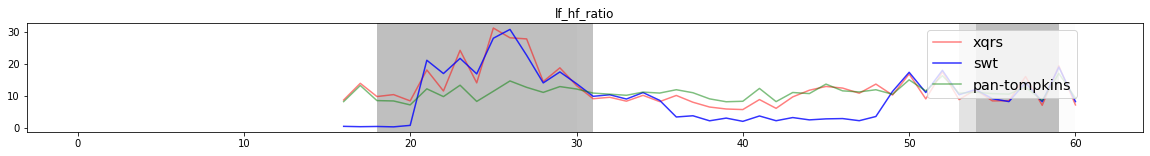

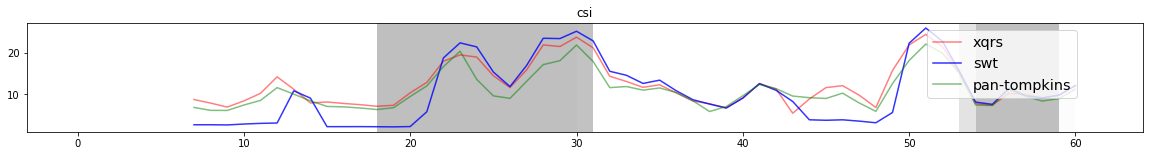

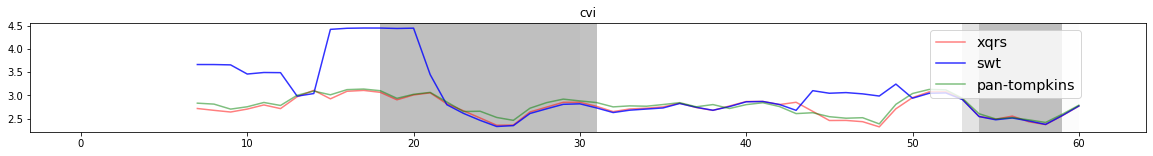

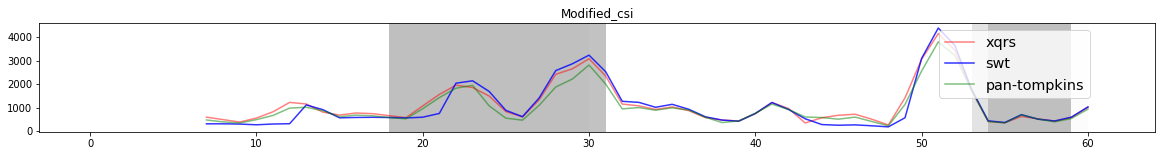

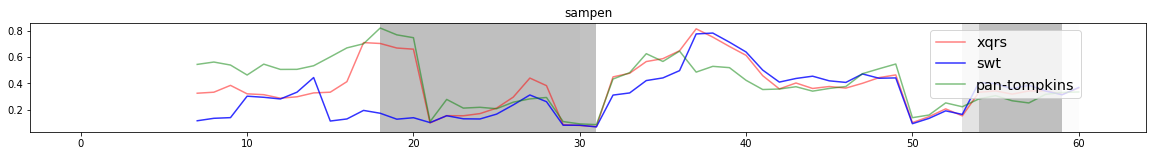

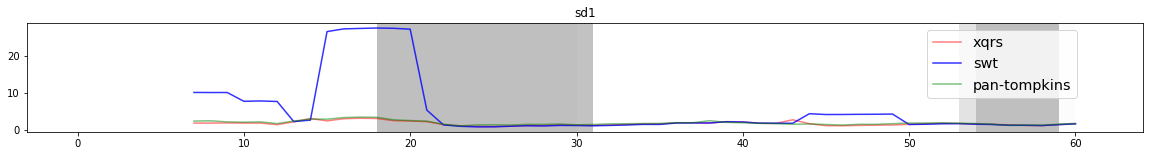

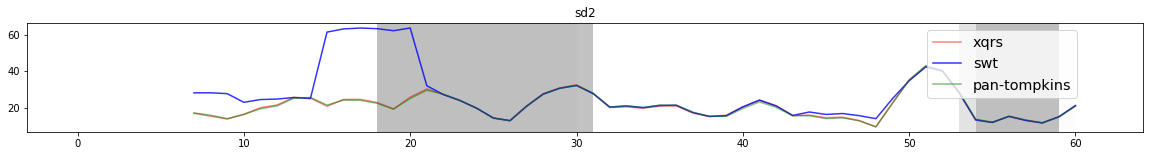

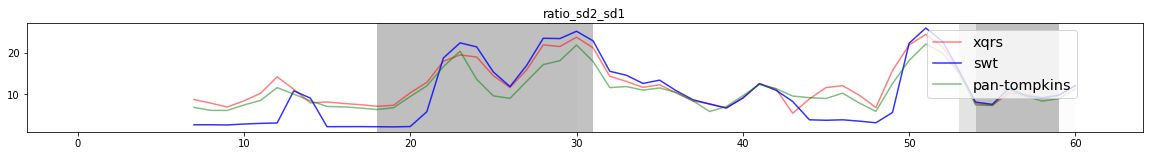

In [41]:
XQRS_FEATS_FILE = "./010520T1514_99perc_seizures/feats_xqrs_median.json"
PAN_TOMPKINS_FEATS_FILE = "./010520T1514_99perc_seizures/feats_pantom_median.json"
SWT_FILE = "./010520T1514_99perc_seizures/feats_swt_median.json"

xqrs_data = json.load(open(XQRS_FEATS_FILE, "r"))
panTompkins_data = json.load(open(PAN_TOMPKINS_FEATS_FILE, "r"))
swt_data = json.load(open(SWT_FILE, "r"))

xqrs_features = np.array(xqrs_data["features"])
panTompkins_features = np.array(panTompkins_data["features"])
swt_features = np.array(swt_data["features"])

xqrs_features_tp = np.transpose(xqrs_features)
panTompkins_features_tp = np.transpose(panTompkins_features)
swt_features_tp =np.transpose(swt_features)

for i in range(0, len(xqrs_data["keys"][:-1])):
    plt.figure(1, figsize = (20,2))
    #print(xqrs_data["keys"][i])
    plt.title(xqrs_data["keys"][i])
    plt.plot(xqrs_features_tp[i], color='red', alpha=0.5, label="xqrs")
    plt.plot(panTompkins_features_tp[i], color='blue', alpha=0.8, label="swt")
    plt.plot(swt_features_tp[i], color='green', alpha=0.5, label="pan-tompkins")
    plt.legend(bbox_to_anchor=(0.80, 1), loc='upper left', fontsize='x-large')
    
    for j in range(0, len(xqrs_features_tp[29])):
        plt.axvspan(j, (j + 1), facecolor='grey', alpha=0.5 * xqrs_features_tp[29][j])
    plt.plot()
    plt.show()